### Prerequisite Packages

In [43]:
import sys
import os
import matplotlib.pyplot as plt
import seaborn as sns
import pandas as pd
import numpy as np
import torch
import torch.optim as optim
import torch.nn as nn
import torch.nn.functional as F
from torch.utils.data import DataLoader, Dataset, WeightedRandomSampler
from torcheval.metrics import BinaryPrecision, BinaryRecall, BinaryF1Score, BinaryAccuracy
from sklearn.model_selection import train_test_split, KFold
from sklearn.metrics import confusion_matrix

In [44]:
sys.path.append('../')

from modules.cross_attentionb import CrossAttentionB
from modules.dataloader import load_npy_files
from modules.classifier import DenseLayer, BCELoss, CustomLoss, BCEWithLogits
from modules.linear_transformation import LinearTransformations

### Data Loading

In [45]:
class MultimodalDataset(Dataset):
    def __init__(self, id_label_df, text_features, audio_features, video_features):
        self.id_label_df = id_label_df
        
        # Convert feature lists to dictionaries for fast lookup
        self.text_features = {os.path.basename(file).split('.')[0]: tensor for file, tensor in text_features}
        self.audio_features = {os.path.basename(file).split('_')[1].split('.')[0]: tensor for file, tensor in audio_features}
        self.video_features = {os.path.basename(file).split('_')[0]: tensor for file, tensor in video_features}

        # List to store missing files
        self.missing_files = []

        # Filter out entries with missing files
        self.valid_files = self._filter_valid_files()

    def _filter_valid_files(self):
        valid_indices = []
        missing_files = []

        for idx in range(len(self.id_label_df)):
            imdbid = self.id_label_df.iloc[idx]['IMDBid']

            # Check if the IMDBid exists in each modality's features
            if imdbid in self.text_features and imdbid in self.audio_features and imdbid in self.video_features:
                valid_indices.append(idx)
            else:
                missing_files.append({'IMDBid': imdbid})

        # Filter id_label_df to only include valid rows
        self.id_label_df = self.id_label_df.iloc[valid_indices].reset_index(drop=True)
        self.missing_files = missing_files
        
        # Update valid_indices to reflect the new indices after resetting
        valid_indices = list(range(len(self.id_label_df)))

        # Return valid indices
        return valid_indices

    def __len__(self):
        return len(self.valid_files)

    def __getitem__(self, idx):
        # Get the original index from the filtered valid files
        original_idx = self.valid_files[idx]
        imdbid = self.id_label_df.iloc[original_idx]['IMDBid']
        label = self.id_label_df.iloc[original_idx]['Label']

        # Retrieve data from the loaded features
        text_data = self.text_features.get(imdbid, torch.zeros((1024,)))
        audio_data = self.audio_features.get(imdbid, torch.zeros((1, 197, 768)))
        video_data = self.video_features.get(imdbid, torch.zeros((95, 768)))
        
        # Define label mapping
        label_map = {'red': 1, 'green': 0} 
        
        # Convert labels to tensor using label_map
        try:
            label_data = torch.tensor([label_map[label]], dtype=torch.float32)
        except KeyError as e:
            print(f"Error: Label '{e}' not found in label_map.")
            raise

        return imdbid, text_data, audio_data, video_data, label_data


In [46]:
def collate_fn(batch):
    # Unpack batch elements
    imdbids, text_data, audio_data, video_data, label_data = zip(*batch)

    # Convert lists to tensors
    text_data = torch.stack(text_data)
    audio_data = torch.stack(audio_data)

    # Padding for video data
    # Determine maximum length of video sequences in the batch
    video_lengths = [v.size(0) for v in video_data]
    max_length = max(video_lengths)

    # Pad video sequences to the maximum length
    video_data_padded = torch.stack([
        F.pad(v, (0, 0, 0, max_length - v.size(0)), "constant", 0)
        for v in video_data
    ])

    # Convert labels to tensor and ensure the shape [batch_size, 1]
    label_data = torch.stack(label_data)  # Convert list of tensors to a single tensor

    return imdbids, text_data, audio_data, video_data_padded, label_data


In [47]:
# Function to calculate and print the size of each DataLoader
def print_dataloader_sizes(dataloader, name):
    total_samples = len(dataloader.dataset)  # Get the size of the dataset
    num_batches = len(dataloader)  # Get the number of batches
    print(f"{name} DataLoader: Total Samples = {total_samples}, Number of Batches = {num_batches}")

In [48]:
# Load the labels DataFrame
id_label_df = pd.read_excel('../../misc/MM-Trailer_dataset.xlsx')

# Define the directories
text_features_dir = '../../misc/text_features'
audio_features_dir = '../../misc/audio_features'
video_features_dir = '../../misc/video_features'

# Load the feature vectors from each directory
text_features = load_npy_files(text_features_dir)
audio_features = load_npy_files(audio_features_dir)
video_features = load_npy_files(video_features_dir)

print(f"Number of text feature vectors loaded: {len(text_features)}")
print(f"Number of audio feature vectors loaded: {len(audio_features)}")
print(f"Number of video feature vectors loaded: {len(video_features)}")

# Drop unnecessary columns
id_label_df = id_label_df.drop(columns=['Movie Title', 'URL'])

full_dataset = MultimodalDataset(id_label_df, text_features, audio_features, video_features)

# perform train-test split on the filtered DataFrame
train_df, val_test_df = train_test_split(
    full_dataset.id_label_df, test_size=0.3, random_state=42, stratify=full_dataset.id_label_df['Label'])

# Further splitting remaining set into validation and test sets
val_df, test_df = train_test_split(
    val_test_df, test_size=0.5, random_state=42, stratify=val_test_df['Label'])

print("train_df shape:", train_df.shape)
print("val_df shape:", val_df.shape)
print("test_df shape:", test_df.shape)

print("Train label distribution:", train_df['Label'].value_counts())
print("Validation label distribution:", val_df['Label'].value_counts())
print("Test label distribution:", test_df['Label'].value_counts())

print("-" * 40)

# create datasets based on these splits
train_dataset = MultimodalDataset(train_df, text_features, audio_features, video_features)
val_dataset = MultimodalDataset(val_df, text_features, audio_features, video_features)
test_dataset = MultimodalDataset(test_df, text_features, audio_features, video_features)

# FOR RESAMPLING Calculate weights for the classes in the training set
class_counts = train_df['Label'].value_counts().to_dict()
class_weights = {label: 1.0 / count for label, count in class_counts.items()}
sample_weights = [class_weights[label] for label in train_df['Label']]
# Initialize the WeightedRandomSampler
weighted_sampler = WeightedRandomSampler(
    weights=sample_weights,
    num_samples=len(sample_weights),
    replacement=True
)
# train_dataloader = DataLoader(train_dataset, batch_size=32, sampler=weighted_sampler, num_workers=0, collate_fn=collate_fn)

# Create DataLoaders
train_dataloader = DataLoader(train_dataset, batch_size=16, shuffle=True, num_workers=0, collate_fn=collate_fn)
val_dataloader = DataLoader(val_dataset, batch_size=16, shuffle=True, num_workers=0, collate_fn=collate_fn)
test_dataloader = DataLoader(test_dataset, batch_size=16, shuffle=False, num_workers=0, collate_fn=collate_fn)

# Print sizes of each DataLoader
print_dataloader_sizes(train_dataloader, "Train")
print_dataloader_sizes(val_dataloader, "Validation")
print_dataloader_sizes(test_dataloader, "Test")

Number of text feature vectors loaded: 1353
Number of audio feature vectors loaded: 1353
Number of video feature vectors loaded: 1353
train_df shape: (947, 2)
val_df shape: (203, 2)
test_df shape: (203, 2)
Train label distribution: Label
green    707
red      240
Name: count, dtype: int64
Validation label distribution: Label
green    151
red       52
Name: count, dtype: int64
Test label distribution: Label
green    152
red       51
Name: count, dtype: int64
----------------------------------------
Train DataLoader: Total Samples = 947, Number of Batches = 60
Validation DataLoader: Total Samples = 203, Number of Batches = 13
Test DataLoader: Total Samples = 203, Number of Batches = 13


### Hyperparameters and Important Assignments

In [49]:
# Device configuration
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
print(f"Device: {device}")

# !!! Choose if pytorch's multiheadattention or own crossattention
isMultiHead = True 
num_heads = 1

# Modality assignments
modality_assignments = {
    'modalityAlpha': 'audio_features',
    'modalityBeta': 'text_features',
    'modalityGamma': 'video_features'
}

# Define the loss function
isBCELoss = True                          # !!! SET ACCORDINGLY !!!
criterion = BCELoss()
# criterion = BCEWithLogits()
# criterion = CustomLoss(pos_weight=2.94)  

# Hyperparameters
threshold = 0.5        # for predictions
learning_rate = 1e-3
dropout_rate = 0.3   # for FinalClassifier
num_epochs = 10       # Set the number of epochs you want to train for

# !!! Choose Classifier !!! False = Dense Layer, True = Final Classifier
isFinalClassifier = True

Device: cpu


### Important Functions

In [50]:
# Cross Attention Function
def PairCrossAttention(modalityAlpha, modalityBeta, d_out_kq=768, d_out_v=768):
    cross_attn = CrossAttentionB(modalityAlpha.shape[-1], modalityBeta.shape[-1], d_out_kq, d_out_v)
    modalityAlphaBeta = cross_attn(modalityAlpha, modalityBeta)
    return modalityAlphaBeta

In [51]:
class MultiheadCrossAttention(nn.Module):
    def __init__(self, embed_dim, num_heads=num_heads):
        super().__init__()
        self.multihead_attn = nn.MultiheadAttention(embed_dim, num_heads, batch_first=True)
        
    def forward(self, query, key_value):
        # Ensure inputs are 3D: (batch_size, sequence_length, embed_dim)
        if query.dim() == 2:
            query = query.unsqueeze(1)  # Add sequence length dimension
        if key_value.dim() == 2:
            key_value = key_value.unsqueeze(1)  # Add sequence length dimension
            
        output, _ = self.multihead_attn(query, key_value, key_value)
        return output

### SMCA Functions and Model

In [52]:
def SMCAStage1(modalityAlpha, modalityBeta, d_out_kq, d_out_v, device):
    
    if isMultiHead: 
        cross_attn = MultiheadCrossAttention(d_out_v).to(device)
    else:
        cross_attn = CrossAttentionB(modalityAlpha.shape[-1], modalityBeta.shape[-1], d_out_kq, d_out_v).to(device)

    # Cross-attention: Alpha -> Beta
    alphaBeta = cross_attn(modalityAlpha, modalityBeta)  # Shape: (batch_size, num_queries, d_out_v)

    # Cross-attention: Beta -> Alpha
    betaAlpha = cross_attn(modalityBeta, modalityAlpha)  # Shape: (batch_size, num_kv, d_out_v)

    # Get the sequence lengths
    seq_len_alpha = alphaBeta.size(1)  # This is num_queries
    seq_len_beta = betaAlpha.size(1)    # This is num_kv

    # Instead of expanding, use padding or trimming
    max_seq_len = max(seq_len_alpha, seq_len_beta)

    # Ensure both alphaBeta and betaAlpha are of shape (batch_size, max_seq_len, d_out_v)
    if seq_len_alpha < max_seq_len:
        alphaBeta = torch.nn.functional.pad(alphaBeta, (0, 0, 0, max_seq_len - seq_len_alpha), value=0)

    if seq_len_beta < max_seq_len:
        betaAlpha = torch.nn.functional.pad(betaAlpha, (0, 0, 0, max_seq_len - seq_len_beta), value=0)

    # Concatenate cross-attention outputs along the feature dimension (-1)
    modalityAlphaBeta = torch.cat((alphaBeta, betaAlpha), dim=-1)  # Shape: (batch_size, max_seq_len, 2 * d_out_v)

    return modalityAlphaBeta


In [53]:
class ProjectionLayer(nn.Module):
    def __init__(self, input_dim, output_dim):
        super(ProjectionLayer, self).__init__()
        self.linear = nn.Linear(input_dim, output_dim)

    def forward(self, x):
        return self.linear(x)

In [54]:
def SMCAStage2(modalityAlphaBeta, modalityGamma, d_out_kq, d_out_v, device):
    # modalityAlphaBeta: (batch_size, seq_len, 2 * d_out_v) [output of Stage 1]
    
    # Initialize the projection layer for modalityAlphaBeta
    projection_layer = ProjectionLayer(modalityAlphaBeta.shape[-1], d_out_v).to(device)

    # Project modalityAlphaBeta to (batch_size, seq_len, d_out_v)
    modalityAlphaBetaProjected = projection_layer(modalityAlphaBeta)

    # Initialize the cross-attention module
    if isMultiHead: 
        cross_attn = MultiheadCrossAttention(d_out_v).to(device)
    else:
        cross_attn = CrossAttentionB(modalityAlphaBetaProjected.shape[-1], modalityGamma.shape[-1], d_out_kq, d_out_v).to(device)

    # Cross-attention: AlphaBeta -> Gamma
    alphaBetaGamma = cross_attn(modalityAlphaBetaProjected, modalityGamma)  # Shape: (batch_size, seq_len_alphaBeta, d_out_v)

    # Cross-attention: Gamma -> AlphaBeta
    gammaAlphaBeta = cross_attn(modalityGamma, modalityAlphaBetaProjected)  # Shape: (batch_size, seq_len_gamma, d_out_v)

    # Get the sequence lengths for both modalities
    seq_len_alphaBeta = alphaBetaGamma.size(1)
    seq_len_gamma = gammaAlphaBeta.size(1)

    # Pad the smaller sequence to match the larger one (expanding to before)
    max_seq_len = max(seq_len_alphaBeta, seq_len_gamma)

    if seq_len_alphaBeta < max_seq_len:
        alphaBetaGamma = torch.nn.functional.pad(alphaBetaGamma, (0, 0, 0, max_seq_len - seq_len_alphaBeta), value=0)

    if seq_len_gamma < max_seq_len:
        gammaAlphaBeta = torch.nn.functional.pad(gammaAlphaBeta, (0, 0, 0, max_seq_len - seq_len_gamma), value=0)

    # Concatenate along the feature dimension (-1)
    multimodal_representation = torch.cat((alphaBetaGamma, gammaAlphaBeta), dim=-1)  # Shape: (batch_size, max(seq_len_alphaBeta, seq_len_gamma), 2 * d_out_v)

    # Apply Global Average Pooling across the feature (sequence to before)
    GAP = torch.mean(multimodal_representation, dim=1)  # Shape: (batch_size, 2 * d_out_v)

    return GAP

In [55]:
class SMCAModel(nn.Module):
    def __init__(self, d_out_kq, d_out_v, device):
        super(SMCAModel, self).__init__()
        self.d_out_kq = d_out_kq
        self.d_out_v = d_out_v
        self.device = device
    
    def forward(self, modalityAlpha, modalityBeta, modalityGamma):
        # Stage 1: Cross attention between modalityAlpha and modalityBeta
        modalityAlphaBeta = SMCAStage1(modalityAlpha, modalityBeta, self.d_out_kq, self.d_out_v, self.device)

        # Stage 2: Cross attention with modalityAlphaBeta (as query) and modalityGamma (as key-value)
        multimodal_representation = SMCAStage2(modalityAlphaBeta, modalityGamma, self.d_out_kq, self.d_out_v, self.device)

        return multimodal_representation

In [56]:
def train_model(model, dense_layer, dataloader, criterion, optimizer, device):
    model.train()
    dense_layer.train()
    total_loss = 0.0

    # Initialize metrics for binary classification
    precision_metric = BinaryPrecision().to(device)
    recall_metric = BinaryRecall().to(device)
    f1_metric = BinaryF1Score().to(device)
    accuracy_metric = BinaryAccuracy().to(device) 
    
    # Reset metrics at the start of training
    precision_metric.reset()
    recall_metric.reset()
    f1_metric.reset()
    accuracy_metric.reset()

    print("-" * 20, "Train", "-" * 20)

    for imdbids, text_features, audio_features, video_features, targets in dataloader:
        text_features, audio_features, video_features, targets = (
            text_features.to(device),
            audio_features.to(device),
            video_features.to(device),
            targets.to(device).view(-1)
        )
                
        # Squeeze the audio features to remove the extra dimension
        audio_features = audio_features.squeeze(1) 

        # Apply linear transformations to match dimensions
        linear_transform_text = LinearTransformations(text_features.shape[-1], 768)   

        # Transform features to match the target dimension
        text_features = linear_transform_text(text_features)    
        
        transformed_features = {
            'audio_features': audio_features,
            'text_features': text_features,
            'video_features': video_features
        }

        outputs = model(
            modalityAlpha=transformed_features[modality_assignments['modalityAlpha']],  # Use the dictionary for modality assignment
            modalityBeta=transformed_features[modality_assignments['modalityBeta']],
            modalityGamma=transformed_features[modality_assignments['modalityGamma']]
        )

        # Pass the fused features through the dense layer
        predictions = dense_layer(outputs).view(-1)

        # Compute loss
        loss = criterion(predictions, targets)
        total_loss += loss.item()
        
        # Backward pass and optimization
        optimizer.zero_grad()
        loss.backward()
        optimizer.step()

        # !!!Apply if BCEWithLogits or CustomLoss!!!
        if not isBCELoss:
            predictions = torch.sigmoid(predictions)

        # Apply threshold to get binary predictions
        preds = (predictions >= threshold).float()
        
        # Update metrics for binary classification
        precision_metric.update(preds.long(), targets.long())
        recall_metric.update(preds.long(), targets.long())
        f1_metric.update(preds.long(), targets.long())
        accuracy_metric.update(preds.long(), targets.long()) 

    # Compute average precision, recall, F1 score, and accuracy
    precision = precision_metric.compute().item()
    recall = recall_metric.compute().item()
    f1_score = f1_metric.compute().item()
    accuracy = accuracy_metric.compute().item()  

    train_average_loss = total_loss / len(dataloader)

    print(f"Train Accuracy: {accuracy:.4f}")
    print(f"Train Precision: {precision:.4f}")
    print(f"Train Recall: {recall:.4f}")
    print(f"Train F1 Score: {f1_score:.4f}")
    print(f"Train Loss: {train_average_loss:.4f}")

    return train_average_loss, accuracy, precision, recall, f1_score

In [57]:
def evaluate_model(model, dense_layer, dataloader, criterion, device):
    model.eval()
    dense_layer.eval()
    total_loss = 0.0

    # Initialize the metrics for binary classification
    precision_metric = BinaryPrecision().to(device)
    recall_metric = BinaryRecall().to(device)
    f1_metric = BinaryF1Score().to(device)
    accuracy_metric = BinaryAccuracy().to(device) 

    precision_metric.reset()
    recall_metric.reset()
    f1_metric.reset()
    accuracy_metric.reset()    

    all_predictions = []
    all_targets = []
    
    with torch.no_grad():
         for imbdids, text_features, audio_features, video_features, targets in dataloader:
            text_features, audio_features, video_features, targets = (
                text_features.to(device),
                audio_features.to(device),
                video_features.to(device),
                targets.to(device).view(-1)
            )
        
            # Squeeze the audio features to remove the extra dimension
            audio_features = audio_features.squeeze(1) 

            # Apply linear transformations to match dimensions
            linear_transform_text = LinearTransformations(text_features.shape[-1], 768)   

            # Transform features to match the target dimension
            text_features = linear_transform_text(text_features)    
            
            transformed_features = {
                'audio_features': audio_features,
                'text_features': text_features,
                'video_features': video_features
            }

            outputs = model(
                modalityAlpha=transformed_features[modality_assignments['modalityAlpha']],  # Use the dictionary for modality assignment
                modalityBeta=transformed_features[modality_assignments['modalityBeta']],
                modalityGamma=transformed_features[modality_assignments['modalityGamma']]
            )

            # Pass the fused features through the dense layer
            predictions = dense_layer(outputs).view(-1)
            
            # Compute loss
            loss = criterion(predictions, targets)
            total_loss += loss.item()

            # !!!Apply if BCEWithLogits or CustomLoss!!!
            if not isBCELoss:
                predictions = torch.sigmoid(predictions)

            # Apply threshold to get binary predictions
            preds = (predictions >= threshold).float()

            all_predictions.extend(predictions.cpu().numpy())
            all_targets.extend(targets.cpu().numpy())
            
            # Print model predictions and targets for each batch
            print("-" * 15, "Eval", "-" * 15)
            print(f"Predictions (raw):  {np.round(predictions.cpu().numpy(), 3)}")            
            print(f"Binary Predictions: {preds.cpu().numpy()}")
            print(f"Targets:            {targets.cpu().numpy()}")
            

            # Update the precision, recall, and F1 score metrics
            precision_metric.update(preds.long(), targets.long())
            recall_metric.update(preds.long(), targets.long())
            f1_metric.update(preds.long(), targets.long())
            accuracy_metric.update(preds.long(), targets.long()) 

     # Compute average precision, recall, F1 score, and accuracy
    precision = precision_metric.compute().item()
    recall = recall_metric.compute().item()
    f1_score = f1_metric.compute().item()
    accuracy = accuracy_metric.compute().item() 
    
    # Calculate confusion matrix
    eval_conf_matrix = confusion_matrix(all_targets, np.round(all_predictions))

    eval_average_loss = total_loss / len(dataloader)
    print(f"Eval Accuracy: {accuracy:.4f}")
    print(f"Eval Precision: {precision:.4f}")
    print(f"Eval Recall: {recall:.4f}")
    print(f"Eval F1 Score: {f1_score:.4f}")
    print(f"Eval Loss: {eval_average_loss:.4f}")
    
    return eval_average_loss, accuracy, precision, recall, f1_score, eval_conf_matrix

In [58]:
def test_model(model, dense_layer, dataloader, criterion, device):
    model.eval()
    dense_layer.eval()
    total_loss = 0

    # Initialize the metrics for binary classification
    precision_metric = BinaryPrecision().to(device)
    recall_metric = BinaryRecall().to(device)
    f1_metric = BinaryF1Score().to(device)
    accuracy_metric = BinaryAccuracy().to(device) 

    all_predictions = []
    all_targets = []
    
    print("-" * 20, "Test", "-" * 20)

    with torch.no_grad():
        for imdbids, text_features, audio_features, video_features, targets in dataloader:
            text_features, audio_features, video_features, targets = (
                text_features.to(device),
                audio_features.to(device),
                video_features.to(device),
                targets.to(device).view(-1)
            )
            
            # Squeeze the audio features to remove the extra dimension
            audio_features = audio_features.squeeze(1) 

            # Apply linear transformations to match dimensions
            linear_transform_text = LinearTransformations(text_features.shape[-1], 768)   

            # Transform features to match the target dimension
            text_features = linear_transform_text(text_features)    
            
            transformed_features = {
                'audio_features': audio_features,
                'text_features': text_features,
                'video_features': video_features
            }

            outputs = model(
                modalityAlpha=transformed_features[modality_assignments['modalityAlpha']],  # Use the dictionary for modality assignment
                modalityBeta=transformed_features[modality_assignments['modalityBeta']],
                modalityGamma=transformed_features[modality_assignments['modalityGamma']]
            )

            # Pass the fused features through the dense layer
            predictions = dense_layer(outputs).view(-1)
                
            # Compute loss
            loss = criterion(predictions, targets)
            total_loss += loss.item()

            # !!!Apply if BCEWithLogits or CustomLoss!!!
            if not isBCELoss:
                predictions = torch.sigmoid(predictions)

            # Apply threshold to get binary predictions
            preds = (predictions >= threshold).float()

            # Collect predictions and targets for the confusion matrix
            all_predictions.extend(preds.cpu().numpy())
            all_targets.extend(targets.cpu().numpy())

            # Print model predictions and targets for each batch
            print("-" * 15, "Test", "-" * 15)
            print(f"Predictions (raw):  {np.round(predictions.cpu().numpy(), 3)}")            
            print(f"Binary Predictions: {preds.cpu().numpy()}")
            print(f"Targets:            {targets.cpu().numpy()}")
            
            # Update metrics for binary classification
            precision_metric.update(preds.long(), targets.long())
            recall_metric.update(preds.long(), targets.long())
            f1_metric.update(preds.long(), targets.long())
            accuracy_metric.update(preds.long(), targets.long()) 

    # Compute average precision, recall, F1 score, and accuracy
    precision = precision_metric.compute().item()
    recall = recall_metric.compute().item()
    f1_score = f1_metric.compute().item()
    accuracy = accuracy_metric.compute().item()
    
    # Generate confusion matrix
    test_conf_matrix = confusion_matrix(all_targets, all_predictions)

    test_average_loss = total_loss / len(dataloader)
    print(f"Test Accuracy: {accuracy:.4f}")
    print(f"Test Precision: {precision:.4f}")
    print(f"Test Recall: {recall:.4f}")
    print(f"Test F1 Score: {f1_score:.4f}")
    print(f"Test Loss: {test_average_loss:.4f}")

    return test_average_loss, accuracy, precision, recall, f1_score, test_conf_matrix



In [59]:
def get_optimizer(parameters, lr=learning_rate):
    # Create an optimizer, for example, Adam
    return optim.Adam(parameters, lr=lr)

In [60]:
class FinalClassifier(nn.Module):
    def __init__(self, input_size, dropout_rate=dropout_rate):
        super(FinalClassifier, self).__init__()
        self.fc1 = nn.Linear(input_size, 512)  # First fully connected layer
        self.bn1 = nn.BatchNorm1d(512)          # Batch normalization after first layer
        self.fc2 = nn.Linear(512, 256)          # Second fully connected layer
        self.bn2 = nn.BatchNorm1d(256)          # Batch normalization after second layer
        self.fc3 = nn.Linear(256, 128)          # Third fully connected layer
        self.bn3 = nn.BatchNorm1d(128)          # Batch normalization after third layer
        self.fc4 = nn.Linear(128, 64)          # Second fully connected layer
        self.bn4 = nn.BatchNorm1d(64)          # Batch normalization after third layer

        self.dropout = nn.Dropout(dropout_rate) # Dropout layer
        self.dense = nn.Linear(64, 1)          # Final dense layer for binary classification
        self.relu = nn.ReLU()                    # ReLU activation
        self.sigmoid = nn.Sigmoid()              # Sigmoid activation for final output

    def forward(self, x):
        x = self.fc1(x)                         # First fully connected layer
        x = self.bn1(x)                         # Apply batch normalization
        x = self.relu(x)                        # Apply ReLU activation

        x = self.fc2(x)                         # second fully connected layer
        x = self.bn2(x)                         # Apply batch normalization
        x = self.relu(x)                        # Apply ReLU activation
        x = self.dropout(x)                     # Apply dropout
        
        x = self.fc3(x)                         # third fully connected layer
        x = self.bn3(x)                         # Apply batch normalization
        x = self.relu(x)                        # Apply ReLU activation

        x = self.fc4(x)                         # fourth fully connected layer
        x = self.bn4(x)                         # Apply batch normalization
        x = self.relu(x)                        # Apply ReLU activation
        x = self.dropout(x)                     # Apply dropout
        
        x = self.dense(x)                       # Final dense layer
        if isBCELoss:
            x = self.sigmoid(x)                  # Apply sigmoid activation
        return x                                 # Output probabilities for BCELoss


In [61]:
def plot_confusion_matrix(conf_matrix, class_names=['Negative', 'Positive']):
    plt.figure(figsize=(6, 5))
    sns.heatmap(conf_matrix, annot=True, fmt="d", cmap="Blues", cbar=False,
                xticklabels=class_names, yticklabels=class_names)
    plt.xlabel('Predicted Labels')
    plt.ylabel('True Labels')
    plt.title('Confusion Matrix')
    plt.show()

In [62]:
# Function to plot training and validation loss
def plot_losses(train_losses, val_losses):
    plt.figure(figsize=(10, 5))
    plt.plot(train_losses, label='Training Loss', color='blue', marker='o')
    plt.plot(val_losses, label='Validation Loss', color='orange', marker='x')
    plt.title('Training and Validation Loss over Epochs')
    plt.xlabel('Epochs')
    plt.ylabel('Loss')
    plt.legend()
    plt.grid()
    plt.show()

----------------------------------------
Epoch 1/10
-------------------- Train --------------------
Train Accuracy: 0.7054
Train Precision: 0.2706
Train Recall: 0.0958
Train F1 Score: 0.1415
Train Loss: 0.6106
--------------- Eval ---------------
Predictions (raw):  [0.375 0.365 0.372 0.35  0.4   0.362 0.365 0.354 0.349 0.375 0.369 0.356
 0.383 0.353 0.345 0.349]
Binary Predictions: [0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0.]
Targets:            [0. 1. 0. 0. 1. 0. 1. 0. 0. 0. 1. 0. 1. 0. 0. 0.]
--------------- Eval ---------------
Predictions (raw):  [0.381 0.393 0.362 0.38  0.395 0.374 0.366 0.384 0.383 0.41  0.388 0.381
 0.382 0.355 0.369 0.369]
Binary Predictions: [0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0.]
Targets:            [0. 1. 0. 1. 0. 1. 1. 0. 0. 1. 1. 0. 0. 0. 1. 0.]
--------------- Eval ---------------
Predictions (raw):  [0.313 0.345 0.345 0.323 0.341 0.358 0.339 0.335 0.376 0.352 0.32  0.353
 0.357 0.336 0.315 0.354]
Binary Predictions: [0. 0. 0. 0. 0. 0. 0. 

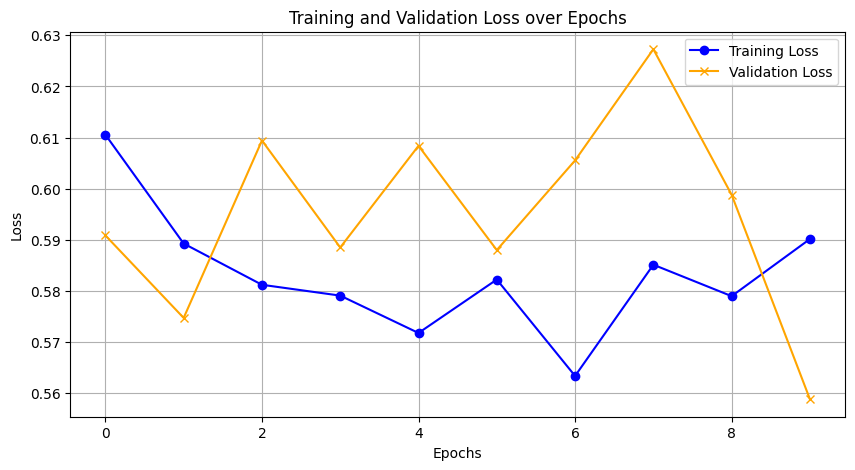

In [63]:
if __name__ == "__main__":
    torch.manual_seed(42)

    # Initialize the SMCA model A
    model = SMCAModel(768, 768, device).to(device)  # Dimension for d_out_kq and d_out_v

    # Determine the output dimensions
    output_dim = 768

    # Own DenseLayer or FinalClassifier
    if isFinalClassifier:
        dense_layer = FinalClassifier(output_dim*2).to(device) 
    else:
        dense_layer = DenseLayer(output_dim*2).to(device)

    optimizer = get_optimizer(list(model.parameters()) + list(dense_layer.parameters()), learning_rate)

    # Lists to store the training and validation losses
    train_losses = []
    val_losses = []

    for epoch in range(num_epochs):
        print("-" * 40)
        print(f"Epoch {epoch + 1}/{num_epochs}")

        # Ensure you have a dataloader that yields inputs and targets
        train_average_loss, accuracy, precision, recall, f1_score = train_model(model=model, dense_layer=dense_layer, dataloader=train_dataloader, criterion=criterion, optimizer=optimizer, device=device)
        train_losses.append(train_average_loss)  # Store training loss
        
        for name, param in model.named_parameters():
            if param.grad is None:
                print("After train: model:", "No gradient for:", name)
        
        for name, param in dense_layer.named_parameters():
            if param.grad is None:
                print("After train: classifier:", "No gradient for:", name)

        # Validate step
        eval_average_loss, accuracy, precision, recall, f1_score, eval_conf_matrix = evaluate_model(model=model, dense_layer=dense_layer, dataloader=val_dataloader, criterion=criterion, device=device)
        val_losses.append(eval_average_loss)  # Store validation loss
        print(eval_conf_matrix)
        # print(f"Training Loss: {train_average_loss:.4f}, Validation Loss: {eval_average_loss:.4f}")

    # Testing the model
    print("-" * 40)
    print("Testing the model on the test set...")
    test_average_loss, accuracy, precision, recall, f1_score, test_conf_matrix = test_model(model=model, dense_layer=dense_layer, dataloader=test_dataloader, criterion=criterion, device=device)
    print("Confusion Matrix:", test_conf_matrix)
    

    plot_losses(train_losses, val_losses)
    # plot_confusion_matrix(test_conf_matrix)